# Colab Imports

In [178]:
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [179]:
!pip -q install langgraph langchain_openai langchain_community tiktoken konlpy

# Settings & Loadings

In [180]:
import os
import json
import pandas as pd

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

PROFECT_DIR = os.path.join("/content/drive/MyDrive", "Profect SAE")
CSVs = os.path.join(PROFECT_DIR, "test_data/CSVs")
files = os.listdir(CSVs)
csv_files = [
    file for file in files
      if file.endswith(".csv")
]

df_one = pd.read_csv(os.path.join(CSVs, csv_files[0]))
print(df_one.iloc[0])

title      [종합] 김태희, 해외서 권총 강도 당했다…'연매출 1100억' 정샘물 "피해액 2...
url        https://m.entertain.naver.com/article/312/0000...
content    본문 바로가기 naver 엔터 뉴스 스포츠 사용자 링크 로그인 검색 홈 드라마 영화...
Name: 0, dtype: object


# Models & Schema
- `gpt-4o-mini`
- `text-embedding-3-large`

In [181]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [182]:
from pydantic import BaseModel, Field
from typing import Optional, List

class RequestDto(BaseModel):
  title: str = Field(..., min_length=1)
  url: str = Field(..., min_length=5, max_length=2083)
  content: str = Field(..., min_length=1)

# Nodes, Agents & Tools
- Agents
  - `preprocessing_routing_agent`
  - `preprocessing_closing_agent`
- Supporting Nodes
  - `naver_news_preprocessing`
  - `naver_entertainment_preprocessing`
  - `naver_sports_preprocessing`
  - `youtube_preprocessing`
- Tools
  - `text_cleaning`

## Agents
- `preprocessing_routing_agent`
- `preprocessing_closing_agent`

In [183]:
import re

def preprocessing_routing_agent(requestDto: RequestDto) -> dict:
    youtube_pattern = r"^https?://(www\.)?youtube\.com"
    naver_news_pattern = r"^https?://n\.news\.naver\.com"
    naver_entertainment_pattern = r"^https?://m\.entertain\.naver\.com"
    naver_sports_pattern = r"^https?://m\.sports\.naver\.com"

    if re.match(naver_news_pattern, requestDto.url):
        route = "naver_news"

    elif re.match(naver_entertainment_pattern, requestDto.url):
        route = "naver_entertainment"

    elif re.match(naver_sports_pattern, requestDto.url):
        route = "naver_sports"

    elif re.match(youtube_pattern, requestDto.url):
        route = "youtube"
    else:
        route = "default"

    # Basic text cleaning

    ## Title
    requestDto.title = text_cleaning(requestDto.title)

    ## Content
    requestDto.content = text_cleaning(requestDto.content)

    # Add route to the requestDto and return as a dictionary
    return {"requestDto": requestDto, "route": route}

In [184]:
korean_stopwords = [
    "아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가",
    "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면",
    "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다",
    "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에",
    "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여",
    "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야",
    "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다",
    "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써",
    "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등",
    "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼",
    "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한",
    "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면",
    "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다",
    "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기",
    "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여",
    "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하",
    "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳",
    "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉",
    "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩",
    "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는",
    "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면",
    "인젠", "이젠", "된바에야", "된이상", "만큼", "어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면",
    "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서",
    "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고",
    "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래",
    "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작하여", "시초에", "이상", "허",
    "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안",
    "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저",
    "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까",
    "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것",
    "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것",
    "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다",
    "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "년", "월",
    "일", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉"
]

In [185]:
from konlpy.tag import Okt

def preprocessing_closing_agent(requestDto) -> RequestDto:
  content = requestDto['requestDto'].content
  okt = Okt()
  content_tokens = okt.morphs(content)

  result = [
      word for word in content_tokens
        if not word in korean_stopwords
      ]
  reqest_dto = RequestDto(title=requestDto['requestDto'].title, url=requestDto['requestDto'].url, content=" ".join(result))
  # request_dto = requestDto['requestDto']
  return request_dto

In [186]:
from langchain.prompts import PromptTemplate

def generation_model(requestDto):
  template = "Title: {title} URL: {url} Content: {content}"
  message = template.format(title=requestDto.title, url=requestDto.url, content=requestDto.content)
  prompt = PromptTemplate.from_template("Based on following information give me the related company: {topic}")
  formatted_prompt = prompt.format(topic=message)
  # Invoke the llm with the message string
  print(llm.invoke(formatted_prompt).content)
  return requestDto

### Tools
- `text_cleaning`

In [187]:
from langchain_core.tools import tool

@tool
def text_cleaning(text: str) -> str:
    """Cleaning text by removing unnecessary characters and spaces."""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove leading and trailing spaces
        text = text.strip()
        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)
        # Remove special characters except for common ones
        text = re.sub(r'[^\w\s.,!?$%&@()-]', '', text)
    return text

## Nodes
- `naver_news_preprocessing`
- `naver_entertainment_preprocessing`
- `naver_sports_preprocessing`
- `youtube_preprocessing`

In [188]:
import re


def content_preprocessing(text: str, remove_after: str = None, patterns: list = None) -> str:
    if not isinstance(text, str):
        return text

    if remove_after:
        text = re.sub(fr"{remove_after}.*", "", text, flags=re.IGNORECASE)

    if patterns:
      combined_pattern = "|".join(patterns)
      text = re.sub(combined_pattern, "", text, flags=re.IGNORECASE)

    # Remove excessive whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

def preprocessing_naver_news(requestDto):
    """Cleans Naver News content."""
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, remove_after="copyright .*?\. all rights reserved")
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, remove_after="기사 공유하기")
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, patterns = [
            r"본문 바로가기", r"naver", r"뉴스", r"엔터", r"스포츠", r"날씨", r"프리미엄",
            r"사용자 링크", r"로그인", r"서비스", r"더보기", r"검색", r"언론사별", r"정치",
            r"경제", r"사회", r"생활문화", r"it과학", r"세계", r"랭킹", r"신문보기",
            r"오피니언", r"tv", r"팩트체크", r"알고리즘 안내", r"정정보도 모음"])
    return requestDto

def preprocessing_naver_entertainment(requestDto):
    """Cleans Naver Entertainment content."""
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, remove_after="copyright .*?\. all rights reserved")
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, remove_after="기사 공유하기")
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, patterns = [r"본문 바로가기", r"naver", r"엔터", r"뉴스", r"스포츠", r"사용자 링크", r"로그인", r"검색", r"홈",
                                                                                                           r"드라마", r"영화", r"뮤직", r"연애", r"포토", r"랭킹", r"최신뉴스", r"연재", r"종합"])
    return requestDto

def preprocessing_naver_sports(requestDto):
    """Cleans Naver Sports content."""
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, remove_after="copyright .*?\. all rights reserved")
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, remove_after="기사 공유하기")
    return requestDto

def preprocessing_youtube(requestDto):
    """Cleans YouTube transcript content."""
    requestDto['requestDto'].content = content_preprocessing(requestDto['requestDto'].content, remove_after="더보기")
    return requestDto

# Flow

In [190]:
from langgraph.graph import Graph, START, END

workflow = Graph()

# Registring Nodes
workflow.add_node("preprocessing_routing_agent",preprocessing_routing_agent)
workflow.add_node("preprocessing_naver_news",preprocessing_naver_news)
workflow.add_node("preprocessing_naver_entertainment",preprocessing_naver_entertainment)
workflow.add_node("preprocessing_naver_sports",preprocessing_naver_sports)
workflow.add_node("preprocessing_youtube",preprocessing_youtube)
workflow.add_node("preprocessing_closing_agent", preprocessing_closing_agent)
# workflow.add_node("generation_model", generation_model)

# Registring edges
## START
workflow.add_edge(START, "preprocessing_routing_agent")

## Conditional Edges
workflow.add_conditional_edges(
    "preprocessing_routing_agent",
    lambda output: output["route"],
    {
        "naver_news": "preprocessing_naver_news",
        "naver_entertainment": "preprocessing_naver_entertainment",
        "naver_sports": "preprocessing_naver_sports",
        "youtube": "preprocessing_youtube",
        "default": "preprocessing_closing_agent",
    }
)

## Edges
workflow.add_edge("preprocessing_naver_news", "preprocessing_closing_agent")
workflow.add_edge("preprocessing_naver_entertainment", "preprocessing_closing_agent")
workflow.add_edge("preprocessing_naver_sports", "preprocessing_closing_agent")
## End
workflow.add_edge("preprocessing_youtube", "preprocessing_closing_agent")
workflow.add_edge("preprocessing_closing_agent", END)
# workflow.add_edge("preprocessing_closing_agent", "generation_model")
# workflow.add_edge("generation_model", END)

# Compiling
preprocessing_flow = workflow.compile()

# Visualization

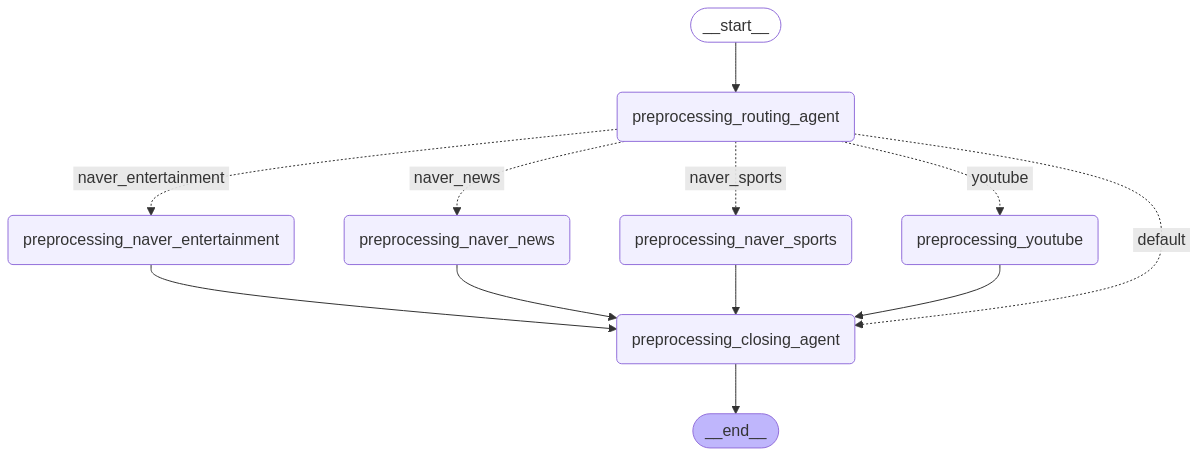

In [191]:
# Visualize your graph
from IPython.display import Image, display
png = preprocessing_flow.get_graph().draw_mermaid_png()
display(Image(png))

# Test

In [192]:
import tiktoken
def token_counter(request_dto):
  encoding = tiktoken.get_encoding("cl100k_base")

  result = len(encoding.encode(request_dto.title))
  result += len(encoding.encode(request_dto.url))
  result += len(encoding.encode(request_dto.content))

  return result

In [193]:
before_avg_count = 0
after_avg_count = 0
row_count = 0
for row in df_one.itertuples():
  before_count = token_counter(row)
  before_avg_count += before_count
  print(f"Number of tokens before preprocessing {before_count}")
  print()
  request_dto = RequestDto(title=row.title, url=row.url, content=row.content)
  preprocessed_request_dto = preprocessing_flow.invoke(request_dto)
  # print(preprocessed_request_dto)
  after_count = token_counter(preprocessed_request_dto)
  after_avg_count += after_count
  print(f"Number of tokens after preprocessing with multi-agents {after_count}")
  print()
  print(f"Number of token decreased {before_count-after_count}")
  print("----------------------------------------------------")
  print()
  row_count+=1
  # break

print(f"Average number of tokens before preprocessing {int(before_avg_count/row_count)}")
print(f"Average number of tokens after preprocessing with multi-agents {int(after_avg_count/row_count)}")
print(f"Average number of tokens decreased {int((before_avg_count-after_avg_count)/row_count)}")

Number of tokens before preprocessing 2878

Number of tokens after preprocessing with multi-agents 1387

Number of token decreased 1491
----------------------------------------------------

Number of tokens before preprocessing 2854

Number of tokens after preprocessing with multi-agents 1379

Number of token decreased 1475
----------------------------------------------------

Number of tokens before preprocessing 3521

Number of tokens after preprocessing with multi-agents 1981

Number of token decreased 1540
----------------------------------------------------

Number of tokens before preprocessing 3007

Number of tokens after preprocessing with multi-agents 1443

Number of token decreased 1564
----------------------------------------------------

Number of tokens before preprocessing 2459

Number of tokens after preprocessing with multi-agents 980

Number of token decreased 1479
----------------------------------------------------

Number of tokens before preprocessing 10727

Number